In [2]:
%reload_ext autoreload
%autoreload 2
import pynwb
import os

#DataJoint and DataJoint schema
import datajoint as dj
import numpy as np
import pandas as pd

## We also import a bunch of tables so that we can call them easily

from spyglass.common import (RawPosition, HeadDir, Speed, LinPos, StateScriptFile, VideoFile,
                                  DataAcquisitionDevice, CameraDevice, Probe,
                                  DIOEvents,
                                  ElectrodeGroup, Electrode, Raw, SampleCount,
                                  LFPSelection, LFP, LFPBandSelection, LFPBand,
                                  FirFilter,
                                  IntervalList,
                                  Lab, LabMember, LabTeam, Institution,
                                  BrainRegion,
                                  SensorData,
                                  Session, ExperimenterList,
                                  Subject,
                                  Task, TaskEpoch,
                                  Nwbfile, AnalysisNwbfile, NwbfileKachery, AnalysisNwbfileKachery,
                                  get_electrode_indices)
from spyglass.common.common_position import (PositionInfoParameters,IntervalPositionInfo)
from spyglass.common.common_interval import interval_list_intersect



from plot_lfp import (get_x_y_list, get_speed,get_speed_timestamp, get_pos_timestamp,get_timestamps_and_data,get_electrode_ids,remove_dead_tet_chans,check_for_dead_probes,
                      checking_other_dead_tets,simple_plot,plot_overlay,plot_overlay_with_pos,plot_speed_versus_theta, find_overlapping_times,get_x_y_timestamp_list)

import re
import matplotlib.pyplot as plt
import warnings

warnings.simplefilter('ignore', category=DeprecationWarning)
warnings.simplefilter('ignore', category=ResourceWarning)

from spectral_connectivity import Multitaper
from spectral_connectivity import Connectivity
from spectral_connectivity import multitaper_connectivity

from spectral_connectivity.statistics import fisher_z_transform
from spectral_connectivity.statistics import coherence_bias

from coherence import (multitaper_and_connectivity,get_signal_from_trialtimes, get_CI)

import statistics 
import matplotlib.patches as mpatches
from spyglass.common.common_position import (IntervalLinearizedPosition, IntervalPositionInfo, TrackGraph)





[2022-07-14 13:15:24,257][INFO]: Connecting emonroe@lmf-db.cin.ucsf.edu:3306
[2022-07-14 13:15:24,313][INFO]: Connected emonroe@lmf-db.cin.ucsf.edu:3306


/home/emonroe/miniconda2/envs/spyglass/lib/python3.9/site-packages/position_tools/core.py:3: DeprecationWarning: Please use `gaussian_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter1d


In [3]:
nwb_file_name = 'senor20201030_.nwb'

In [4]:
filename = r'/home/emonroe/Downloads/senor20201030_-Copy1.nwb_TrialsInfoByEpoch.ByTrial.csv'

trial_data = pd.read_csv(filename)
trial_data

trial_data['stem_switch'] = trial_data['stem'].ne(trial_data['stem'].shift())

#will also set the first trial of every session to be a stem switch
for ix in range(trial_data.index.min(), trial_data.index.max()+1): 
    if trial_data.loc[ix,'trial_number_by_epoch']==0:
        trial_data.loc[ix,'stem_switch']= True
    #not sure if this does anything? 
trial_data

nwb_file_name  epoch  trial_number_by_epoch  leaf stem  reward  \
0     senor20201030_.nwb      2                      0     4    B       0   
1     senor20201030_.nwb      2                      1     3    B       0   
2     senor20201030_.nwb      2                      2     2    A       0   
3     senor20201030_.nwb      2                      3     1    A       1   
4     senor20201030_.nwb      2                      4     2    A       1   
...                  ...    ...                    ...   ...  ...     ...   
1255  senor20201030_.nwb     14                    175     1    A       0   
1256  senor20201030_.nwb     14                    176     2    A       1   
1257  senor20201030_.nwb     14                    177     1    A       1   
1258  senor20201030_.nwb     14                    178     2    A       1   
1259  senor20201030_.nwb     14                    179     1    A       0   

        poke_in_ts  reward_on_ts  reward_off_ts   poke_out_ts  ...  \
0     1.604078e+09           NaN            NaN  1.604078e+09  ...   
1     1.604078e+09           NaN            NaN  1.604078e+09  ...   
2     1.604078e+09           NaN            NaN  1.604078e+09  ...   
3     1.604078e+09  1.604078e+09   1.604078e+09  1.604078e+09  ...   
4     1.604078e+09  1.604078e+09   1.604078e+09  1.604078e+09  ...   
...            ...           ...            ...           ...  ...   
1255  1.604104e+09           NaN            NaN  1.604104e+09  ...   
1256  1.604104e+09  1.604104e+09   1.604104e+09  1.604104e+09  ...   
1257  1.604104e+09  1.604104e+09   1.604104e+09  1.604104e+09  ...   
1258  1.604104e+09  1.604104e+09   1.604104e+09  1.604104e+09  ...   
1259  1.604104e+09           NaN            NaN  1.604104e+09  ...   

      p_rew_leaf5  p_rew_leaf6  decay_percent  p_rew_reset_leaf1  \
0              20           80            NaN                NaN   
1              20           80            NaN                NaN   
2              20           80            NaN                NaN   
3              20           80            NaN                NaN   
4              20           80            NaN                NaN   
...           ...          ...            ...                ...   
1255           20           50            NaN                NaN   
1256           20           50            NaN                NaN   
1257           20           50            NaN                NaN   
1258           20           50            NaN                NaN   
1259           20           50            NaN                NaN   

      p_rew_reset_leaf2  p_rew_reset_leaf3  p_rew_reset_leaf4  \
0                   NaN                NaN                NaN   
1                   NaN                NaN                NaN   
2                   NaN                NaN                NaN   
3                   NaN                NaN                NaN   
4                   NaN                NaN                NaN   
...                 ...                ...                ...   
1255                NaN                NaN                NaN   
1256                NaN                NaN                NaN   
1257                NaN                NaN                NaN   
1258                NaN                NaN                NaN   
1259                NaN                NaN                NaN   

      p_rew_reset_leaf5  p_rew_reset_leaf6  stem_switch  
0                   NaN                NaN         True  
1                   NaN                NaN        False  
2                   NaN                NaN         True  
3                   NaN                NaN        False  
4                   NaN                NaN        False  
...                 ...                ...          ...  
1255                NaN                NaN        False  
1256                NaN                NaN        False  
1257                NaN                NaN        False  
1258                NaN                NaN        False  
1259     

In [16]:
epoch_pos = [[2, 1],[4,8],[6 , 10],[8 ,12],[10,14],[12,3],[14,5]]


In [5]:
epoch_pos = [[2, 1],[4,8],[6 , 10],[8 ,12],[10,14],[12,3],[14,5]]


list_seg_switch=[]

#for each epoch
for epoch in range(2,16,2):
    #seperate 1 epoch
    #load the trial data for each epoch individually just to compare trial times and pos times which are by the epoch 
    trial_data_sesh = trial_data[trial_data.epoch==epoch]
    
    #get the start/stop trial times
    trial_times=[]
    #for each session, find the poke in and out times, save those to a list
    for ix in range(1,len(trial_data_sesh)):
        trial_start = trial_data_sesh.iloc[ix-1].poke_out_ts
        trial_end = trial_data_sesh.iloc[ix].poke_in_ts
        trial_times.append([trial_start, trial_end])
    
    #use the epoch pos from above to get the corresponding pos # for the epoch, frm the pic alison send to me
    #if this wasnt correct, the code would break so thats a relief! 
    
    for ix in range(len(epoch_pos)):
        if epoch_pos[ix][0]==epoch:
            pos_num = epoch_pos[ix][1]
    
    #get the position and linearized position info for that epoch 
    position_info = (IntervalPositionInfo() &
                     {'nwb_file_name': nwb_file_name,
                      'interval_list_name': f'pos {pos_num} valid times',
                      'position_info_param_name': 'default'}
                    ).fetch1_dataframe()
    # position_info

    linear_position_df= (IntervalLinearizedPosition() &
                         {'position_info_param_name': 'default',
                          'nwb_file_name': nwb_file_name,
                          'interval_list_name': f'pos {pos_num} valid times',
                          'track_graph_name': 'senor20201030',
                          'linearization_param_name': 'default',
                         }).fetch1_dataframe()
    # linear_position_df
    #get the track segment switch times from linearized position
    linear_position_df['track_segment_id_switch'] = linear_position_df['track_segment_id'].ne(linear_position_df['track_segment_id'].shift())
    
    seg_switch_times = linear_position_df[linear_position_df.track_segment_id_switch==True].index
    
    #find the segement switch times for each trial individually 
    trials_seg_switch_times = []
    for ix in range(len(trial_times)):
        #one inidividual trials start and end times 
        trial_start = trial_times[ix][0]
        trial_end = trial_times[ix][1]
        #find the segment switch time that falls within those trial times 
        switch_time_ind_s = seg_switch_times>=trial_start
        switch_time_ind_e = seg_switch_times<=trial_end
        trial_switch_times = seg_switch_times[switch_time_ind_s & switch_time_ind_e]
        #make it into a new list- for each trial, each now has a list of 1+ segment switch times  
        trials_seg_switch_times.append(trial_switch_times)
        
    #add a 0 to make it the same length as the df 
    list_seg_switch.append(0)
# add these segment switch times to a new list, which will be added to the total df. this might be a little redundant. 
    for ix in range(len(trials_seg_switch_times)):
        seg_switch_times = trials_seg_switch_times[ix]
        if len(seg_switch_times)==1:
            list_seg_switch.append([seg_switch_times[0]])
        else: 
            list_seg_switch.append(seg_switch_times[0:].tolist())
trial_data['seg_switch_times']=list_seg_switch

In [6]:
len(list_seg_switch)# (should be the legnth of the day df) 

1260

1.0844552516937256 0.8333325386047363 0.7333366870880127 0.9398753643035889
1.0858168601989746 0.8333327770233154 0.7666614055633545 1.1101889610290527
2.4658396244049072 0.79998779296875 0.7666621208190918 0.9955103397369385
1.2537457942962646 0.8666572570800781 2.93330454826355 0.9822924137115479
1.2721354961395264 0.8000078201293945 0.7333154678344727 0.9855413436889648
3.2040677070617676 0.7333369255065918 0.7666614055633545 1.1039340496063232
1.419792652130127 0.8666672706604004 0.7999866008758545 1.111553430557251
1.1577057838439941 0.7666606903076172 0.7333152294158936 0.6873183250427246
1.3724086284637451 0.8000068664550781 0.799985408782959 0.7725987434387207
1.371565580368042 0.8000020980834961 0.9999773502349854 0.744455099105835
1.1113386154174805 0.9000029563903809 0.8666565418243408 0.7740015983581543
1.194605827331543 0.8333325386047363 0.766660213470459 0.8224015235900879
2.172398328781128 0.8666567802429199 0.8333315849304199 0.8536133766174316
2.5851593017578125 2.866

([<matplotlib.axis.XTick at 0x7f7b1a5ef5e0>,
 [Text(0, 0, 'out:leaf'),
  Text(1, 0, 'leaf to stem'),
  Text(2, 0, 'stem to leaf'),
  Text(3, 0, 'leaf to in')])

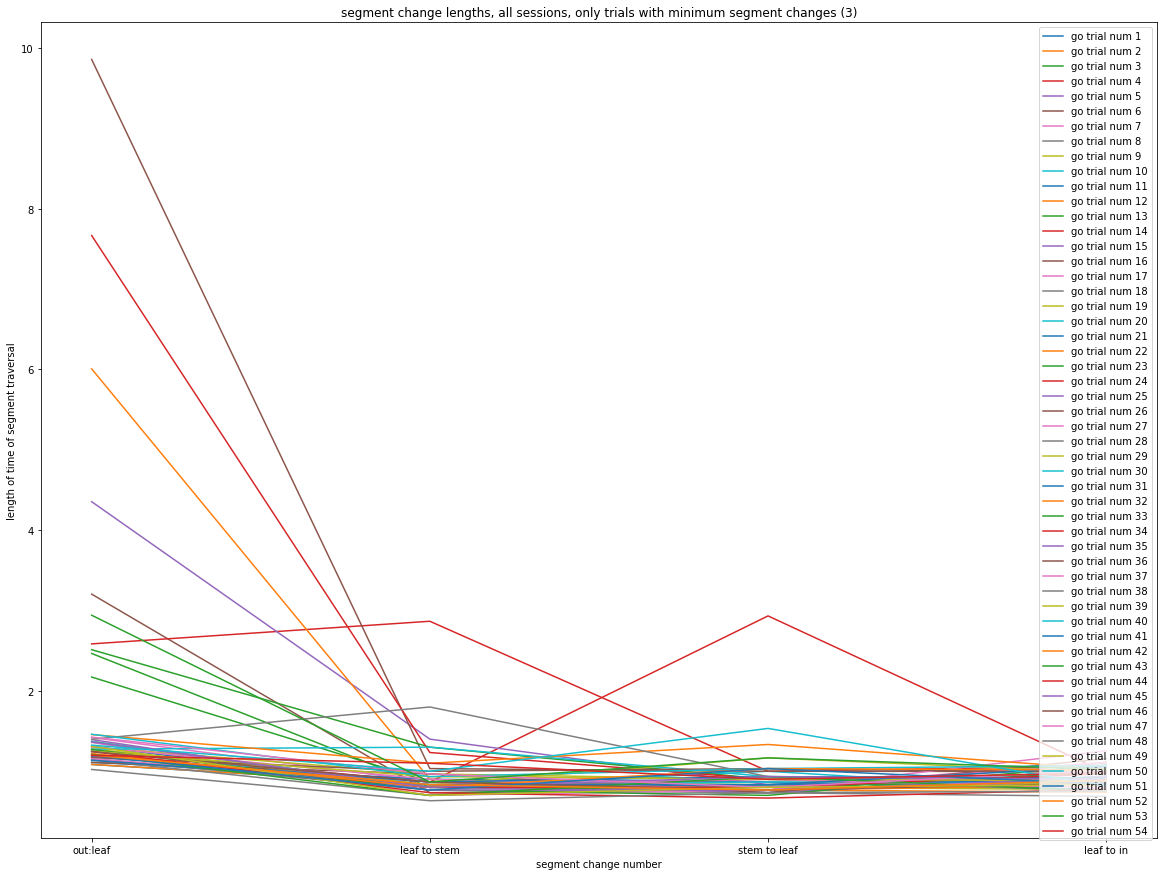

In [12]:
#this cell will, for each go trial, get the trial start time, the segment switch times in between, and the trial end time. Will save these to plot them.

plt.figure(figsize = (20,15))
counter = 1
trial_seg_times_keeper=[]
for ix in range(1,len(trial_data)): 
    if trial_data.iloc[ix].seg_switch_times!=0:
        if trial_data.iloc[ix].stem_switch==True: 
            if len(trial_data.iloc[ix].seg_switch_times) ==3:
                trial_seg_times=[]
                trial_start = trial_data.iloc[ix-1].poke_out_ts
                trial_end = trial_data.iloc[ix].poke_in_ts
                segment_change_times = trial_data.iloc[ix].seg_switch_times
                seg_1 = segment_change_times[0]-trial_start
                seg_2 = segment_change_times[1]-segment_change_times[0]
                seg_3 = segment_change_times[2]-segment_change_times[1]
                seg_4=trial_end - segment_change_times[2]
                trial_seg_times.append([seg_1,seg_2,seg_3,seg_4])
                trial_seg_times_keeper.append([seg_1,seg_2,seg_3,seg_4])
                print(seg_1,seg_2,seg_3,seg_4)
                # plt.figure()
                plt.plot(trial_seg_times[0],label=f'go trial num {counter}')
                counter= counter+1
                plt.legend(loc='upper right')
plt.title('segment change lengths, all sessions, only trials with minimum segment changes (3)')
plt.xlabel('segment change number')
plt.ylabel('length of time of segment traversal')
plt.xticks([0,1,2,3],['out:leaf','leaf to stem','stem to leaf','leaf to in'])

([<matplotlib.axis.YTick at 0x7f7b1a1d84f0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

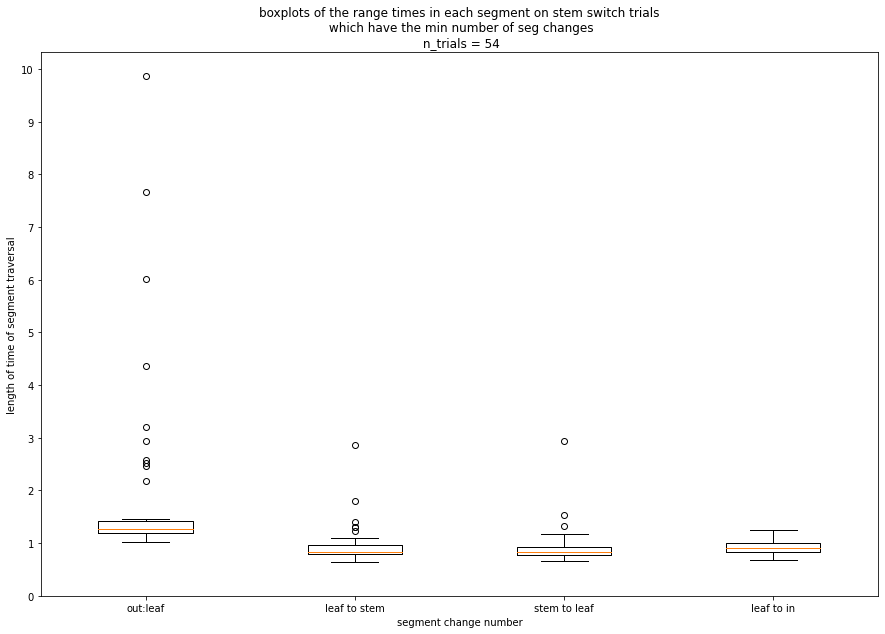

In [13]:
#split them up (basically a hacky version of axis = 0 to make boxplot etc 
seg1=[]
seg2=[]
seg3=[]
seg4=[]
seg_keeper=[]
plt.figure(figsize=(15,10))
for ix in range(len(trial_seg_times_keeper)): 
    seg1.append(trial_seg_times_keeper[ix][0])
    seg2.append(trial_seg_times_keeper[ix][1])
    seg3.append(trial_seg_times_keeper[ix][2])
    seg4.append(trial_seg_times_keeper[ix][3])
# plt.boxplot(seg1,positions=[1])
# plt.boxplot(seg2,positions=[2])
# plt.boxplot(seg3,positions=[3])
# plt.boxplot(seg4,positions=[4])
plt.boxplot([seg1,seg2,seg3,seg4],positions= [1,2,3,4])

plt.title(f'boxplots of the range times in each segment on stem switch trials\n which have the min number of seg changes\n n_trials = {len(seg1)}')
plt.xlabel('segment change number')
plt.ylabel('length of time of segment traversal')
plt.xticks([1,2,3,4],['out:leaf','leaf to stem','stem to leaf','leaf to in'])
plt.yticks([0,1,2,3,4,5,6,7,8,9,10])


In [8]:
lfp_timestamps, lfp_data, lfp_eseries = get_timestamps_and_data(nwb_file_name,data_type = ['lfp'])



In [9]:
electrode_id = [8,17,40,132,244,300]

sampling_rate = sampling_frequency = 1000
time_halfbandwidth_product=1.5
time_window_duration=.5
time_window_step=None


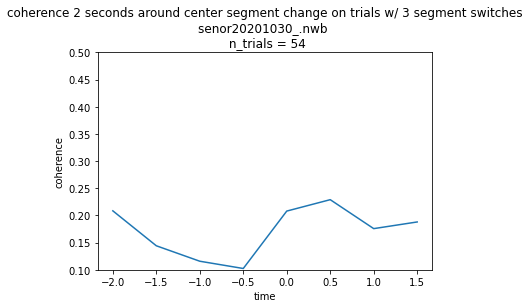

In [189]:
#This is where i start messing around with getting confidence intervals. Didn;t do this until the end of testing, and modified function 
#that gets the coherence, in case it doesnt work later (need new inputs/ outputs)
# stem switch trials, 2 seconds around middle segment change, only 3 segment switches 
from coherence import get_CI 
coher_keeper=[]


trial_keeper_middle=[]
for ix in range(1,len(trial_data)): 
    if trial_data.iloc[ix].seg_switch_times!=0:
        if trial_data.iloc[ix].stem_switch==True: 
            if len(trial_data.iloc[ix].seg_switch_times) ==3:
                trial_keeper_middle.append(trial_data.iloc[ix].seg_switch_times[1])


time_b4 = time_after = 2
electrode_id_temp =[8,132]

    
signal = get_signal_from_trialtimes(trial_keeper_middle, time_b4,time_after, electrode_id_temp, lfp_eseries, lfp_timestamps, lfp_data)


    
time, freq, mag, power,n_trials,z_transform,num_tapers = multitaper_and_connectivity(signal,sampling_frequency,time_halfbandwidth_product,time_window_duration,time_window_step,-time_b4)

coh_seg = mag()[..., 0, 1].squeeze().T[(freq[0] == 8)]
coher_keeper.append(coh_seg[0])

plt.plot(time,coher_keeper[0])
plt.title(f'coherence 2 seconds around center segment change on trials w/ 3 segment switches\n{nwb_file_name} \n n_trials = {n_trials}')
plt.xlabel('time') 
plt.ylabel('coherence')
plt.ylim(.1,.5)

ci_pos, ci_neg = get_CI(z_transform, n_trials, num_tapers)

Text(0.5, 1.0, 'coherence with z transform +-std')

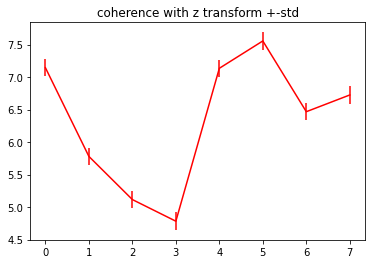

In [190]:
plt.errorbar(range(len(z_transform)),z_transform,
            yerr=ci_pos,
            color = 'r')
plt.title('coherence with z transform +-std')

Text(0.5, 1.0, 'coherence with z transform +-std')

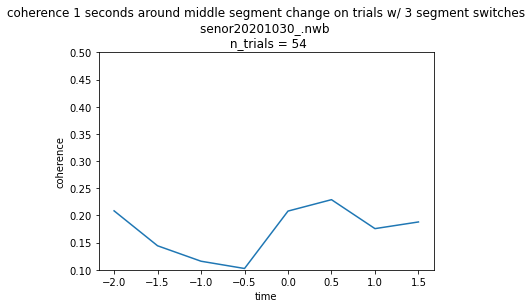

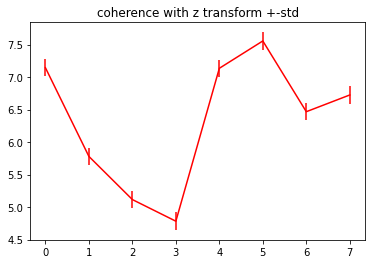

In [191]:
#1 second before and after last segment change on switch trials with only 3 segment changes 
time_at_center = []
coher_keeper=[]

seg_switch = 1

for ix in range(1,len(trial_data)): 
    if trial_data.iloc[ix].seg_switch_times!=0:
        if trial_data.iloc[ix].stem_switch==True: 
            if len(trial_data.iloc[ix].seg_switch_times) ==3:
                # print(trial_data.iloc[ix].seg_switch_times[1])
                time_at_center.append(trial_data.iloc[ix].seg_switch_times[seg_switch])

time_b4 = time_after = 2
electrode_id_temp =[8,132]

    
signal = get_signal_from_trialtimes(time_at_center, time_b4,time_after, electrode_id_temp, lfp_eseries, lfp_timestamps, lfp_data)


    
time, freq, mag, power,n_trials,z_transform,num_tapers = multitaper_and_connectivity(signal,sampling_frequency,time_halfbandwidth_product,time_window_duration,time_window_step,-time_b4)
ci_pos, ci_neg = get_CI(z_transform, n_trials, num_tapers)

coh_seg = mag()[..., 0, 1].squeeze().T[(freq[0] == 8)]
coher_keeper.append(coh_seg[0])

if seg_switch ==0: 
    segment='first'
if seg_switch==1:
    segment='middle'
if seg_switch==2:
    segment='last'


plt.plot(time,coher_keeper[0])
plt.title(f'coherence 1 seconds around {segment} segment change on trials w/ 3 segment switches\n{nwb_file_name} \n n_trials = {n_trials}')
plt.xlabel('time') 
plt.ylabel('coherence')
plt.ylim(.1,.5)


plt.figure() 
plt.errorbar(range(len(z_transform)),z_transform,
            yerr=ci_pos,
            color = 'r')
plt.title('coherence with z transform +-std')

NameError: name 'time_before' is not defined

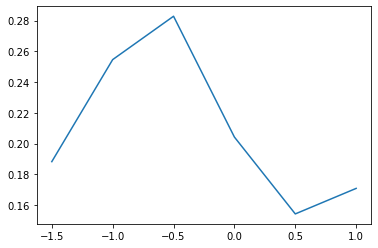

In [67]:

coher_keeper=[]
time_at_center = []

for ix in range(1,len(trial_data)): 
    if trial_data.iloc[ix].seg_switch_times!=0:
        if trial_data.iloc[ix].stem_switch==False: 
            if len(trial_data.iloc[ix].seg_switch_times) ==1:
                time_at_center.append(trial_data.iloc[ix].seg_switch_times[0])

time_b4 = time_after = 1.5
electrode_id_temp =[8,132]

    
signal = get_signal_from_trialtimes(time_at_center, time_b4,time_after, electrode_id_temp, lfp_eseries, lfp_timestamps, lfp_data)


    
time, freq, mag, power,n_trials = multitaper_and_connectivity(signal,sampling_frequency,time_halfbandwidth_product,time_window_duration,time_window_step,-time_b4)

coh_seg = mag()[..., 0, 1].squeeze().T[(freq[0] == 8)]
coher_keeper.append(coh_seg[0])



plt.plot(time,coher_keeper[0])
plt.title(f'coherence {time_b4} seconds around segment change on stay trials trials w/ 1 segment switch\n{nwb_file_name} \n n_trials = {n_trials}')
plt.xlabel('time') 
plt.ylabel('coherence')                
plt.ylim(.1,.5)        
                

([<matplotlib.axis.XTick at 0x7f39bdad2610>], [Text(1, 0, 'hpc → pfc')])

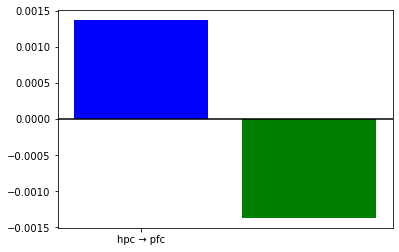

In [18]:
# #testing123
coher_keeper=[]
time_at_center = []

for ix in range(1,len(trial_data)): 
    if trial_data.iloc[ix].seg_switch_times!=0:
        if trial_data.iloc[ix].stem_switch==False: 
            if len(trial_data.iloc[ix].seg_switch_times) ==1:
                time_at_center.append(trial_data.iloc[ix].seg_switch_times[0])

time_b4 = time_after = 1.5
electrode_id_temp =[8,132]

    
signal = get_signal_from_trialtimes(time_at_center, time_b4,time_after, electrode_id_temp, lfp_eseries, lfp_timestamps, lfp_data)


m = Multitaper(signal,
               sampling_frequency=sampling_frequency,
               time_halfbandwidth_product=time_halfbandwidth_product,
               start_time=-time_b4)
c = Connectivity(fourier_coefficients=m.fft(),
                 frequencies=m.frequencies,
                 time=m.time)
# # plt.figure()
# plt.plot(c.frequencies, c.power()[..., 0].squeeze())
# plt.figure()
# plt.plot(c.frequencies, c.power()[..., 1].squeeze())
# plt.figure()
# plt.plot(c.frequencies, c.coherence_magnitude()[..., 0, 1].squeeze())
# plt.figure()
# plt.plot(c.frequencies, c.coherence_phase()[..., 0, 1].squeeze(), linestyle='None', marker='8')

delay, slope, r_value = c.group_delay(frequencies_of_interest=[8,], frequency_resolution=m.frequency_resolution)
plt.figure()
plt.bar([1, 2], [delay[..., 0, 1].squeeze(), delay[..., 1, 0].squeeze()], color=['b', 'g']);
plt.xlim((0.5, 2.5))
plt.hlines(0,0,2.5, color='black');
plt.xticks([1],['hpc → pfc'])
# plt.xticks(['hpc → pfc'])

#not spanning frequencies i care abou


In [72]:
for ix in range(2,trial_data.epoch.max(),2):
    print(ix)


2
4
6
8
10
12


(0.0, 0.5)

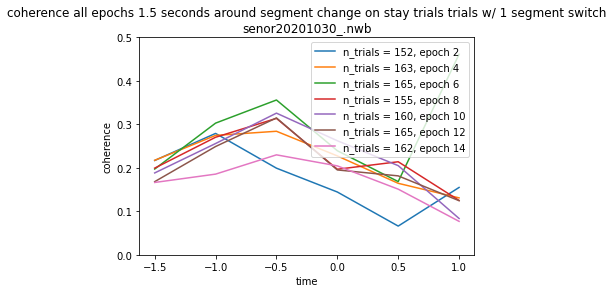

In [177]:
# coher_keeper=[]
time_at_center = []
for epoch in range(2,trial_data.epoch.max()+2,2):
    coher_keeper=[]


    time_at_center = []
    trial_data_epoch= trial_data[trial_data.epoch==epoch]
    for ix in range(1,len(trial_data_epoch)): 
        if trial_data_epoch.iloc[ix].seg_switch_times!=0:
            if trial_data_epoch.iloc[ix].stem_switch==False: 
                if len(trial_data_epoch.iloc[ix].seg_switch_times) ==1:
                    time_at_center.append(trial_data_epoch.iloc[ix].seg_switch_times[0])

    time_b4 = time_after = 1.5
    electrode_id_temp =[8,132]


    signal = get_signal_from_trialtimes(time_at_center, time_b4,time_after, electrode_id_temp, lfp_eseries, lfp_timestamps, lfp_data)



    time, freq, mag, power,n_trials = multitaper_and_connectivity(signal,sampling_frequency,time_halfbandwidth_product,time_window_duration,time_window_step,-time_b4)
    coher_keeper=[]


    coh_seg = mag()[..., 0, 1].squeeze().T[(freq[0] == 8)]
    coher_keeper.append(coh_seg[0])


    # plt.figure()
    plt.plot(time,coher_keeper[0],label= f'n_trials = {n_trials}, epoch {epoch}')
 
    plt.legend()
plt.title(f'coherence all epochs {time_b4} seconds around segment change on stay trials trials w/ 1 segment switch\n{nwb_file_name}')
plt.xlabel('time') 
plt.ylabel('coherence')                
plt.ylim(0,.5) 


In [ ]:
#want to redo how i've been doing the stem stuff. 

(0.0, 0.5)

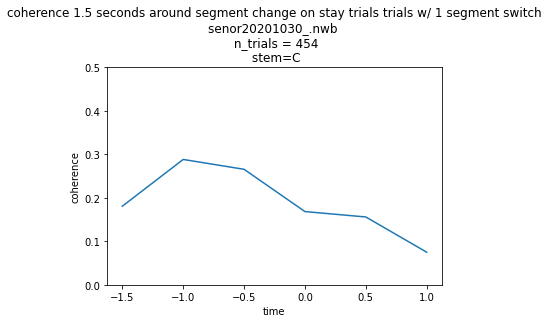

In [81]:
coher_keeper=[]
time_at_center = []
stem='C'

for ix in range(1,len(trial_data)): 
    if trial_data.iloc[ix].seg_switch_times!=0:
        if trial_data.iloc[ix].stem_switch==False: 
            if len(trial_data.iloc[ix].seg_switch_times) ==1:
                if trial_data.iloc[ix].stem==stem:
                    time_at_center.append(trial_data.iloc[ix].seg_switch_times[0])

time_b4 = time_after = 1.5
electrode_id_temp =[8,132]

    
signal = get_signal_from_trialtimes(time_at_center, time_b4,time_after, electrode_id_temp, lfp_eseries, lfp_timestamps, lfp_data)


    
time, freq, mag, power,n_trials = multitaper_and_connectivity(signal,sampling_frequency,time_halfbandwidth_product,time_window_duration,time_window_step,-time_b4)

coh_seg = mag()[..., 0, 1].squeeze().T[(freq[0] == 8)]
coher_keeper.append(coh_seg[0])



plt.plot(time,coher_keeper[0])
plt.title(f'coherence {time_b4} seconds around segment change on stay trials trials w/ 1 segment switch\n{nwb_file_name} \n n_trials = {n_trials}\n stem={stem}')
plt.xlabel('time') 
plt.ylabel('coherence')                
plt.ylim(0,.5)        
                

In [17]:
halflife=3
# trial_times['rew_rate'] =trial_times.groupby(obj)[['reward']].transform(lambda x: x.rolling(10, 1).mean())
# trial_times['rew_rate_ewm'] =trial_times.groupby(obj)[['reward']].transform(lambda x: x.ewm(10, 1).mean())
obj = ['epoch','stem','leaf']
trial_data['rew_rate_ewm_leaf'] =trial_data.groupby(obj)[['reward']].apply(lambda x: x.ewm(halflife).mean())
obj = ['epoch','stem']
trial_data['rew_rate_ewm_stem'] =trial_data.groupby(obj)[['reward']].apply(lambda x: x.ewm(halflife).mean())
obj = ['epoch']
trial_data['rew_rate_ewm_epoch'] =trial_data.groupby(obj)[['reward']].apply(lambda x: x.ewm(halflife).mean())

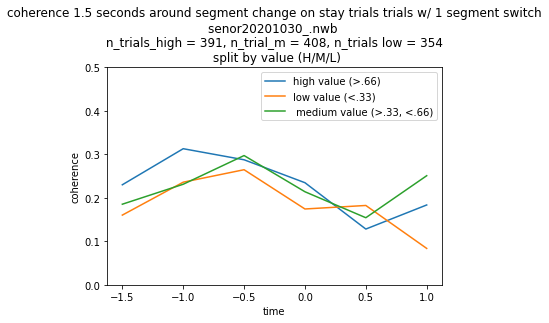

In [192]:
coher_keeper=[]
time_at_center_high_v = []
time_at_center_medium_v=[]
time_at_center_low_v=[]
# stem='C'

for ix in range(1,len(trial_data)): 
    if trial_data.iloc[ix].seg_switch_times!=0:
        if trial_data.iloc[ix].stem_switch==False: 
            if len(trial_data.iloc[ix].seg_switch_times) ==1:
                if trial_data.iloc[ix].rew_rate_ewm_leaf>.66:
                    time_at_center_high_v.append(trial_data.iloc[ix].seg_switch_times[0])
                elif  trial_data.iloc[ix].rew_rate_ewm_leaf<.33: 
                    time_at_center_low_v.append(trial_data.iloc[ix].seg_switch_times[0])
                else: 
                    time_at_center_medium_v.append(trial_data.iloc[ix].seg_switch_times[0])


                    

                    

time_b4 = time_after = 1.5
electrode_id_temp =[8,132]

    
signal = get_signal_from_trialtimes(time_at_center_high_v, time_b4,time_after, electrode_id_temp, lfp_eseries, lfp_timestamps, lfp_data)
signal_low = get_signal_from_trialtimes(time_at_center_low_v, time_b4,time_after, electrode_id_temp, lfp_eseries, lfp_timestamps, lfp_data)
signal_medium = get_signal_from_trialtimes(time_at_center_medium_v, time_b4,time_after, electrode_id_temp, lfp_eseries, lfp_timestamps, lfp_data)


time, freq, mag, power,n_trials,z_transform_high,num_tapers = multitaper_and_connectivity(signal,sampling_frequency,time_halfbandwidth_product,time_window_duration,time_window_step,-time_b4)
ci_pos_high, ci_neg_high= get_CI(z_transform_high, n_trials, num_tapers)
coh_seg = mag()[..., 0, 1].squeeze().T[(freq[0] == 8)]
coher_keeper.append(coh_seg[0])



plt.plot(time,coher_keeper[0],label='high value (>.66)')
# plt.title(f'coherence {time_b4} seconds around segment change on stay trials trials w/ 1 segment switch\n{nwb_file_name} \n n_trials = {n_trials}\n split by value (H/M/L)')#high value (>.66)')
plt.xlabel('time') 
plt.ylabel('coherence')                
plt.ylim(0,.5)        
               
    
coher_keeper=[]


# time, freq, mag, power,n_trials_low = multitaper_and_connectivity(signal_low,sampling_frequency,time_halfbandwidth_product,time_window_duration,time_window_step,-time_b4)
time, freq, mag, power,n_trials,z_transform_low,num_tapers = multitaper_and_connectivity(signal_low,sampling_frequency,time_halfbandwidth_product,time_window_duration,time_window_step,-time_b4)
ci_pos_low, ci_neg_low = get_CI(z_transform_low, n_trials, num_tapers)

coh_seg = mag()[..., 0, 1].squeeze().T[(freq[0] == 8)]

coher_keeper.append(coh_seg[0])


# plt.figure()
plt.plot(time,coher_keeper[0],label='low value (<.33)')
# plt.title(f'coherence {time_b4} seconds around segment change on stay trials trials w/ 1 segment switch\n{nwb_file_name} \n n_trials = {n_trials}\n  lowvalue (<.33)')
plt.xlabel('time') 
plt.ylabel('coherence')                
plt.ylim(0,.5)     


coher_keeper=[]


time, freq, mag, power,n_trials,z_transform_medium,num_tapers = multitaper_and_connectivity(signal_medium,sampling_frequency,time_halfbandwidth_product,time_window_duration,time_window_step,-time_b4)
ci_pos_medium, ci_neg_medium = get_CI(z_transform_medium, n_trials, num_tapers)
coh_seg = mag()[..., 0, 1].squeeze().T[(freq[0] == 8)]

coher_keeper.append(coh_seg[0])


# plt.figure()
plt.plot(time,coher_keeper[0],label=' medium value (>.33, <.66)')
plt.title(f'coherence {time_b4} seconds around segment change on stay trials trials w/ 1 segment switch\n{nwb_file_name} \n n_trials_high = {n_trials_high}, n_trial_m = {n_trials}, n_trials low = {n_trials_low} \n split by value (H/M/L)')#high value (>.66)')
plt.xlabel('time') 
plt.ylabel('coherence')                
plt.ylim(0,.5)
plt.legend()

Text(0.5, 1.0, 'coherence_low with z transform +-std')

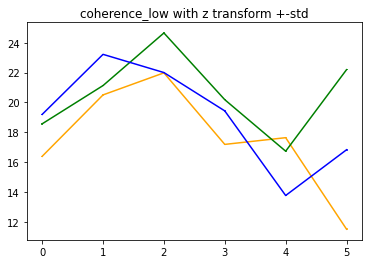

In [193]:
plt.figure() 
plt.errorbar(range(len(z_transform_low)),z_transform_low,
            yerr=ci_pos_low,
            color = 'orange', label='low')
plt.title('coherence_low with z transform +-std')
plt.errorbar(range(len(z_transform_medium)),z_transform_medium,
            yerr=ci_pos_medium,
            color = 'green',label='medium')
plt.title('coherence_low with z transform +-std')
plt.errorbar(range(len(z_transform_high)),z_transform_high,
            yerr=ci_pos_high,
            color = 'blue',label='high')
plt.title('coherence_low with z transform +-std')

In [100]:
trial_data

nwb_file_name  epoch  trial_number_by_epoch  leaf stem  reward  \
0     senor20201030_.nwb      2                      0     4    B       0   
1     senor20201030_.nwb      2                      1     3    B       0   
2     senor20201030_.nwb      2                      2     2    A       0   
3     senor20201030_.nwb      2                      3     1    A       1   
4     senor20201030_.nwb      2                      4     2    A       1   
...                  ...    ...                    ...   ...  ...     ...   
1255  senor20201030_.nwb     14                    175     1    A       0   
1256  senor20201030_.nwb     14                    176     2    A       1   
1257  senor20201030_.nwb     14                    177     1    A       1   
1258  senor20201030_.nwb     14                    178     2    A       1   
1259  senor20201030_.nwb     14                    179     1    A       0   

        poke_in_ts  reward_on_ts  reward_off_ts   poke_out_ts  ...  \
0     1.604078e+09           NaN            NaN  1.604078e+09  ...   
1     1.604078e+09           NaN            NaN  1.604078e+09  ...   
2     1.604078e+09           NaN            NaN  1.604078e+09  ...   
3     1.604078e+09  1.604078e+09   1.604078e+09  1.604078e+09  ...   
4     1.604078e+09  1.604078e+09   1.604078e+09  1.604078e+09  ...   
...            ...           ...            ...           ...  ...   
1255  1.604104e+09           NaN            NaN  1.604104e+09  ...   
1256  1.604104e+09  1.604104e+09   1.604104e+09  1.604104e+09  ...   
1257  1.604104e+09  1.604104e+09   1.604104e+09  1.604104e+09  ...   
1258  1.604104e+09  1.604104e+09   1.604104e+09  1.604104e+09  ...   
1259  1.604104e+09           NaN            NaN  1.604104e+09  ...   

      p_rew_reset_leaf2  p_rew_reset_leaf3  p_rew_reset_leaf4  \
0                   NaN                NaN                NaN   
1                   NaN                NaN                NaN   
2                   NaN                NaN                NaN   
3                   NaN                NaN                NaN   
4                   NaN                NaN                NaN   
...                 ...                ...                ...   
1255                NaN                NaN                NaN   
1256                NaN                NaN                NaN   
1257                NaN                NaN                NaN   
1258                NaN                NaN                NaN   
1259                NaN                NaN                NaN   

      p_rew_reset_leaf5  p_rew_reset_leaf6  stem_switch  \
0                   NaN                NaN         True   
1                   NaN                NaN        False   
2                   NaN                NaN         True   
3                   NaN                NaN        False   
4                   NaN                NaN        False   
...                 ...                ...          ...   
1255                NaN                NaN        False   
1256                NaN                NaN        False   
1257                NaN                NaN        False   
1258                NaN                NaN        False   
1259                NaN                NaN        False   

                                       seg_switch_times  rew_rate_ewm_leaf  \
0                                                     0           0.000000   
1                                  [1604078259.6768906]           0.000000   
2     [1604078268.4768033, 1604078268.810136, 160407...           0.000000   
3                                  [1604078279.2767003]           1.000000   
4                                  [1604078292.4099002]           0.571429   
...                                                 ...                ...   
1255                               [1604103536.0823658]           0.538468   
1256                               [1604103539.3156853]           0.334064   
1257                               [1604103545.748944

In [ ]:
# coher_keeper=[]
# time_at_center_high_v = []
# time_at_center_low_v=[]
# # stem='C'

# for ix in range(1,len(trial_data)): 
#     if trial_data.iloc[ix].seg_switch_times!=0:
#         if trial_data.iloc[ix].stem_switch==False: 
#             # if len(trial_data.iloc[ix].seg_switch_times) ==1:
#                 # if trial_data.iloc[ix].
#             if trial_data.iloc[ix].rew_rate_ewm_epoch>.6:
#                 time_at_center_high_v.append(trial_data.iloc[ix].seg_switch_times[0])
#             elif  trial_data.iloc[ix].rew_rate_ewm_epoch<.4: 
#                 time_at_center_low_v.append(trial_data.iloc[ix].seg_switch_times[0])

                    

# time_b4 = time_after = 1.5
# electrode_id_temp =[8,132]

    
# signal = get_signal_from_trialtimes(time_at_center_high_v, time_b4,time_after, electrode_id_temp, lfp_eseries, lfp_timestamps, lfp_data)
# signal_low = get_signal_from_trialtimes(time_at_center_low_v, time_b4,time_after, electrode_id_temp, lfp_eseries, lfp_timestamps, lfp_data)

    
# time, freq, mag, power,n_trials = multitaper_and_connectivity(signal,sampling_frequency,time_halfbandwidth_product,time_window_duration,time_window_step,-time_b4)

# coh_seg = mag()[..., 0, 1].squeeze().T[(freq[0] == 8)]
# coher_keeper.append(coh_seg[0])



# plt.plot(time,coher_keeper[0])
# plt.title(f'coherence {time_b4} seconds around segment change on stay trials trials w/ 1 segment switch\n{nwb_file_name} \n n_trials = {n_trials}\n epoch ewm high value (>.6)')
# plt.xlabel('time') 
# plt.ylabel('coherence')                
# plt.ylim(0,.5)        
               
    
# coher_keeper=[]


# time, freq, mag, power,n_trials = multitaper_and_connectivity(signal_low,sampling_frequency,time_halfbandwidth_product,time_window_duration,time_window_step,-time_b4)

# coh_seg = mag()[..., 0, 1].squeeze().T[(freq[0] == 8)]

# coher_keeper.append(coh_seg[0])


# plt.figure()
# plt.plot(time,coher_keeper[0])
# plt.title(f'coherence {time_b4} seconds around segment change on stay trials trials w/ 1 segment switch\n{nwb_file_name} \n n_trials = {n_trials}\n epoch ewm lowvalue (<.4)')
# plt.xlabel('time') 
# plt.ylabel('coherence')                
# plt.ylim(0,.5) 

In [13]:
#maybe see if theres more of an effect of the nominal probs 


In [24]:
current_leaf_prob=[]
for ix in range(len(trial_data)):
    current_leaf = trial_data.iloc[ix].leaf
    current_leaf_prob.append(trial_data.iloc[ix][f'p_rew_leaf{current_leaf}'])
trial_data['current_leaf_prob'] = current_leaf_prob

In [23]:
trial_data.iloc[ix][f'p_rew_leaf{current_leaf}']

80

In [19]:
trial_data

nwb_file_name  epoch  trial_number_by_epoch  leaf stem  reward  \
0     senor20201030_.nwb      2                      0     4    B       0   
1     senor20201030_.nwb      2                      1     3    B       0   
2     senor20201030_.nwb      2                      2     2    A       0   
3     senor20201030_.nwb      2                      3     1    A       1   
4     senor20201030_.nwb      2                      4     2    A       1   
...                  ...    ...                    ...   ...  ...     ...   
1255  senor20201030_.nwb     14                    175     1    A       0   
1256  senor20201030_.nwb     14                    176     2    A       1   
1257  senor20201030_.nwb     14                    177     1    A       1   
1258  senor20201030_.nwb     14                    178     2    A       1   
1259  senor20201030_.nwb     14                    179     1    A       0   

        poke_in_ts  reward_on_ts  reward_off_ts   poke_out_ts  ...  \
0     1.604078e+09           NaN            NaN  1.604078e+09  ...   
1     1.604078e+09           NaN            NaN  1.604078e+09  ...   
2     1.604078e+09           NaN            NaN  1.604078e+09  ...   
3     1.604078e+09  1.604078e+09   1.604078e+09  1.604078e+09  ...   
4     1.604078e+09  1.604078e+09   1.604078e+09  1.604078e+09  ...   
...            ...           ...            ...           ...  ...   
1255  1.604104e+09           NaN            NaN  1.604104e+09  ...   
1256  1.604104e+09  1.604104e+09   1.604104e+09  1.604104e+09  ...   
1257  1.604104e+09  1.604104e+09   1.604104e+09  1.604104e+09  ...   
1258  1.604104e+09  1.604104e+09   1.604104e+09  1.604104e+09  ...   
1259  1.604104e+09           NaN            NaN  1.604104e+09  ...   

      p_rew_reset_leaf1  p_rew_reset_leaf2  p_rew_reset_leaf3  \
0                   NaN                NaN                NaN   
1                   NaN                NaN                NaN   
2                   NaN                NaN                NaN   
3                   NaN                NaN                NaN   
4                   NaN                NaN                NaN   
...                 ...                ...                ...   
1255                NaN                NaN                NaN   
1256                NaN                NaN                NaN   
1257                NaN                NaN                NaN   
1258                NaN                NaN                NaN   
1259                NaN                NaN                NaN   

      p_rew_reset_leaf4  p_rew_reset_leaf5  p_rew_reset_leaf6  stem_switch  \
0                   NaN                NaN                NaN         True   
1                   NaN                NaN                NaN        False   
2                   NaN                NaN                NaN         True   
3                   NaN                NaN                NaN        False   
4                   NaN                NaN                NaN        False   
...                 ...                ...                ...          ...   
1255                NaN                NaN                NaN        False   
1256                NaN                NaN                NaN        False   
1257                NaN                NaN                NaN        False   
1258                NaN                NaN                NaN        False   
1259                NaN                NaN                NaN        False   

                                       seg_switch_times  \
0                                                     0   
1                                  [1604078259.6768906]   
2     [1604078268.4768033, 1604078268.810136, 160407...   
3                                  [1604078279.2767003]   
4                                  [1604078292.4099002]   
...                                                 ...   
1255                               [1604103536.0823658]   
1256                               [1604103539.3156853]

(0.0, 0.5)

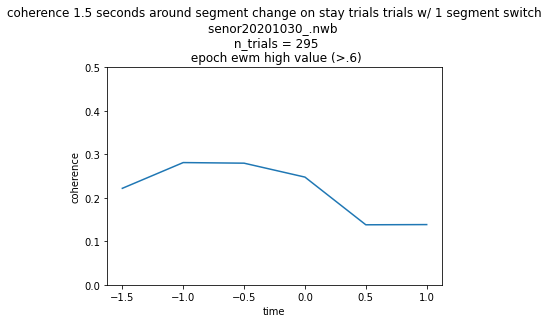

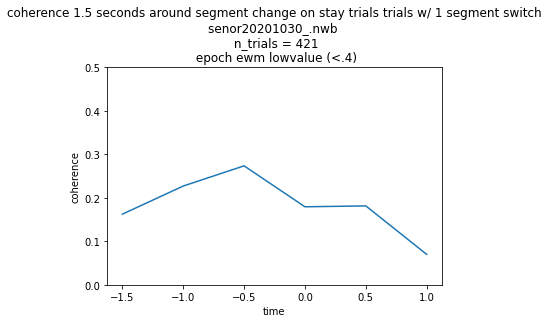

In [34]:
coher_keeper=[]
time_at_center_high_v = []
time_at_center_low_v=[]
# stem='C'

for ix in range(1,len(trial_data)): 
    if trial_data.iloc[ix].seg_switch_times!=0:
        if trial_data.iloc[ix].stem_switch==False: 
            if len(trial_data.iloc[ix].seg_switch_times) ==1:
                if trial_data.iloc[ix].current_leaf_prob>50:
                    time_at_center_high_v.append(trial_data.iloc[ix].seg_switch_times[0])
                elif trial_data.iloc[ix].current_leaf_prob<50: 
                    time_at_center_low_v.append(trial_data.iloc[ix].seg_switch_times[0])

                    

time_b4 = time_after = 1.5
electrode_id_temp =[8,132]

    
signal = get_signal_from_trialtimes(time_at_center_high_v, time_b4,time_after, electrode_id_temp, lfp_eseries, lfp_timestamps, lfp_data)
signal_low = get_signal_from_trialtimes(time_at_center_low_v, time_b4,time_after, electrode_id_temp, lfp_eseries, lfp_timestamps, lfp_data)

    
time, freq, mag, power,n_trials = multitaper_and_connectivity(signal,sampling_frequency,time_halfbandwidth_product,time_window_duration,time_window_step,-time_b4)

coh_seg = mag()[..., 0, 1].squeeze().T[(freq[0] == 8)]
coher_keeper.append(coh_seg[0])



plt.plot(time,coher_keeper[0])
plt.title(f'coherence {time_b4} seconds around segment change on stay trials trials w/ 1 segment switch\n{nwb_file_name} \n n_trials = {n_trials}\n epoch ewm high value (>.6)')
plt.xlabel('time') 
plt.ylabel('coherence')                
plt.ylim(0,.5)        
               
    
coher_keeper=[]
time, freq, mag, power,n_trials = multitaper_and_connectivity(signal_low,sampling_frequency,time_halfbandwidth_product,time_window_duration,time_window_step,-time_b4)

coh_seg = mag()[..., 0, 1].squeeze().T[(freq[0] == 8)]

coher_keeper.append(coh_seg[0])


plt.figure()
plt.plot(time,coher_keeper[0])
plt.title(f'coherence {time_b4} seconds around segment change on stay trials trials w/ 1 segment switch\n{nwb_file_name} \n n_trials = {n_trials}\n epoch ewm lowvalue (<.4)')
plt.xlabel('time') 
plt.ylabel('coherence')                
plt.ylim(0,.5) 

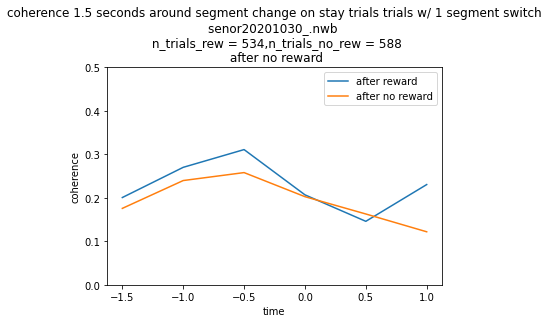

In [25]:
coher_keeper=[]
time_at_center_after_rew = []
time_at_center_no_rew=[]
# stem='C'

for ix in range(1,len(trial_data)): 
    if trial_data.iloc[ix].seg_switch_times!=0:
        if trial_data.iloc[ix].stem_switch==False: 
            if len(trial_data.iloc[ix].seg_switch_times) ==1:
                if trial_data.iloc[ix-1].reward==1:
                    time_at_center_after_rew.append(trial_data.iloc[ix].seg_switch_times[0])
                else: 
                    time_at_center_no_rew.append(trial_data.iloc[ix].seg_switch_times[0])

                
#                 if trial_data.iloc[ix].current_leaf_prob>50:
#                     time_at_center_high_v.append(trial_data.iloc[ix].seg_switch_times[0])
#                 elif trial_data.iloc[ix].current_leaf_prob<50: 
#                     time_at_center_low_v.append(trial_data.iloc[ix].seg_switch_times[0])

                    

time_b4 = time_after = 1.5
electrode_id_temp =[8,132]

    
signal_rew = get_signal_from_trialtimes(time_at_center_after_rew, time_b4,time_after, electrode_id_temp, lfp_eseries, lfp_timestamps, lfp_data)
signal_no_rew = get_signal_from_trialtimes(time_at_center_no_rew, time_b4,time_after, electrode_id_temp, lfp_eseries, lfp_timestamps, lfp_data)

    
time, freq, mag, power,n_trials = multitaper_and_connectivity(signal_rew,sampling_frequency,time_halfbandwidth_product,time_window_duration,time_window_step,-time_b4)

coh_seg = mag()[..., 0, 1].squeeze().T[(freq[0] == 8)]
coher_keeper.append(coh_seg[0])

n_trials_rew = n_trials

plt.plot(time,coher_keeper[0], label = 'after reward')
# plt.title(f'coherence {time_b4} seconds around segment change on stay trials trials w/ 1 segment switch\n{nwb_file_name} \n n_trials = {n_trials}\n after reward vs no rew')
plt.xlabel('time') 
plt.ylabel('coherence')                
plt.ylim(0,.5)        
               
    
coher_keeper=[]
time, freq, mag, power,n_trials = multitaper_and_connectivity(signal_no_rew,sampling_frequency,time_halfbandwidth_product,time_window_duration,time_window_step,-time_b4)

coh_seg = mag()[..., 0, 1].squeeze().T[(freq[0] == 8)]

coher_keeper.append(coh_seg[0])


# plt.figure()
plt.plot(time,coher_keeper[0], label = 'after no reward')
plt.title(f'coherence {time_b4} seconds around segment change on stay trials trials w/ 1 segment switch\n{nwb_file_name} \n n_trials_rew = {n_trials_rew},n_trials_no_rew = {n_trials}\n after no reward')
plt.xlabel('time') 
plt.ylabel('coherence')                
plt.ylim(0,.5) 
plt.legend()

In [28]:
trial_data['bout_num'] = trial_data['stem'].ne(trial_data['stem'].shift()).cumsum()


#adding the length of each bout 
bout_len_lst=[]
for ix in range(1,(trial_data.bout_num.max()+1)):
    bout_len = len(trial_data[trial_data.bout_num == ix])
    bout_len_lst.append((np.ones(bout_len)*bout_len).tolist())
bout_len_list = [item for sublist in bout_len_lst for item in sublist]

trial_data['bout_lens_per_bout']=bout_len_list

# long_bouts = trial_data[trial_data.bout_lens_per_bout>15]

In [29]:
trial_data

nwb_file_name  epoch  trial_number_by_epoch  leaf stem  reward  \
0     senor20201030_.nwb      2                      0     4    B       0   
1     senor20201030_.nwb      2                      1     3    B       0   
2     senor20201030_.nwb      2                      2     2    A       0   
3     senor20201030_.nwb      2                      3     1    A       1   
4     senor20201030_.nwb      2                      4     2    A       1   
...                  ...    ...                    ...   ...  ...     ...   
1255  senor20201030_.nwb     14                    175     1    A       0   
1256  senor20201030_.nwb     14                    176     2    A       1   
1257  senor20201030_.nwb     14                    177     1    A       1   
1258  senor20201030_.nwb     14                    178     2    A       1   
1259  senor20201030_.nwb     14                    179     1    A       0   

        poke_in_ts  reward_on_ts  reward_off_ts   poke_out_ts  ...  \
0     1.604078e+09           NaN            NaN  1.604078e+09  ...   
1     1.604078e+09           NaN            NaN  1.604078e+09  ...   
2     1.604078e+09           NaN            NaN  1.604078e+09  ...   
3     1.604078e+09  1.604078e+09   1.604078e+09  1.604078e+09  ...   
4     1.604078e+09  1.604078e+09   1.604078e+09  1.604078e+09  ...   
...            ...           ...            ...           ...  ...   
1255  1.604104e+09           NaN            NaN  1.604104e+09  ...   
1256  1.604104e+09  1.604104e+09   1.604104e+09  1.604104e+09  ...   
1257  1.604104e+09  1.604104e+09   1.604104e+09  1.604104e+09  ...   
1258  1.604104e+09  1.604104e+09   1.604104e+09  1.604104e+09  ...   
1259  1.604104e+09           NaN            NaN  1.604104e+09  ...   

      p_rew_reset_leaf4  p_rew_reset_leaf5  p_rew_reset_leaf6  stem_switch  \
0                   NaN                NaN                NaN         True   
1                   NaN                NaN                NaN        False   
2                   NaN                NaN                NaN         True   
3                   NaN                NaN                NaN        False   
4                   NaN                NaN                NaN        False   
...                 ...                ...                ...          ...   
1255                NaN                NaN                NaN        False   
1256                NaN                NaN                NaN        False   
1257                NaN                NaN                NaN        False   
1258                NaN                NaN                NaN        False   
1259                NaN                NaN                NaN        False   

                                       seg_switch_times  rew_rate_ewm_leaf  \
0                                                     0           0.000000   
1                                  [1604078259.6768906]           0.000000   
2     [1604078268.4768033, 1604078268.810136, 160407...           0.000000   
3                                  [1604078279.2767003]           1.000000   
4                                  [1604078292.4099002]           0.571429   
...                                                 ...                ...   
1255                               [1604103536.0823658]           0.538468   
1256                               [1604103539.3156853]           0.334064   
1257                               [1604103545.7489443]           0.653879   
1258                               [1604103552.8488734]           0.500588   
1259                               [1604103559.7154639]           0.490380   

      rew_rate_ewm_stem  rew_rate_ewm_epoch  bout_num  bout_lens_per_bout  
0              0.000000            0.000000         1                 2.0  
1              0.000000            0.000000         1                 2.0  
2              0.000000            0.000000         2                 6.0  
3              0.571429            0.365714         2              

In [45]:
one_epoch = trial_data[trial_data.epoch ==4]

In [46]:
# long vs short bouts
coher_keeper=[]
time_at_center_short_bouts = []
time_at_center_long_bouts=[]
# stem='C'

for ix in range(1,len(trial_data)): 
    if trial_data.iloc[ix].seg_switch_times!=0:
        if trial_data.iloc[ix].stem_switch==False: 
            if len(trial_data.iloc[ix].seg_switch_times) ==1:
                if trial_data.iloc[ix].bout_lens_per_bout>20:
                    time_at_center_long_bouts.append(trial_data.iloc[ix].seg_switch_times[0])
                else: 
                    time_at_center_short_bouts.append(trial_data.iloc[ix].seg_switch_times[0])
                    

time_b4 = time_after = 1.5
electrode_id_temp =[8,132]

    
signal_long_bouts = get_signal_from_trialtimes(time_at_center_long_bouts, time_b4,time_after, electrode_id_temp, lfp_eseries, lfp_timestamps, lfp_data)
signal_short_bouts = get_signal_from_trialtimes(time_at_center_short_bouts, time_b4,time_after, electrode_id_temp, lfp_eseries, lfp_timestamps, lfp_data)

    
time, freq, mag, power,n_trials = multitaper_and_connectivity(signal_long_bouts,sampling_frequency,time_halfbandwidth_product,time_window_duration,time_window_step,-time_b4)

coh_seg = mag()[..., 0, 1].squeeze().T[(freq[0] == 8)]
coher_keeper.append(coh_seg[0])

n_trials_long = n_trials

plt.plot(time,coher_keeper[0], label = 'long bouts')
# plt.title(f'coherence {time_b4} seconds around segment change on stay trials trials w/ 1 segment switch\n{nwb_file_name} \n n_trials = {n_trials}\n after reward vs no rew')
plt.xlabel('time') 
plt.ylabel('coherence')                
plt.ylim(0,.5)        
               
    
coher_keeper=[]
time, freq, mag, power,n_trials = multitaper_and_connectivity(signal_short_bouts,sampling_frequency,time_halfbandwidth_product,time_window_duration,time_window_step,-time_b4)

coh_seg = mag()[..., 0, 1].squeeze().T[(freq[0] == 8)]

coher_keeper.append(coh_seg[0])


# plt.figure()
plt.plot(time,coher_keeper[0], label = 'short bouts')
plt.title(f'coherence {time_b4} seconds around segment change on stay trials trials w/ 1 segment switch\n{nwb_file_name} \n n_trials long = {n_trials_long},n_trials short = {n_trials}\n long vs short bouts\n eppch = 4')
plt.xlabel('time') 
plt.ylabel('coherence')                
plt.ylim(0,.5) 
plt.legend()

KeyboardInterrupt: 

Text(0, 0.5, 'count')

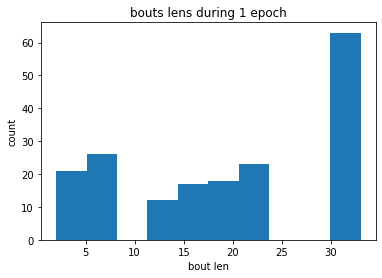

In [39]:
plt.hist(one_epoch['bout_lens_per_bout'])
plt.title('bouts lens during 1 epoch')
plt.xlabel('bout len')
plt.ylabel('count')

In [53]:
for ix in (range(2,(trial_data.epoch.max()+2),2)):
    print(ix)

2
4
6
8
10
12


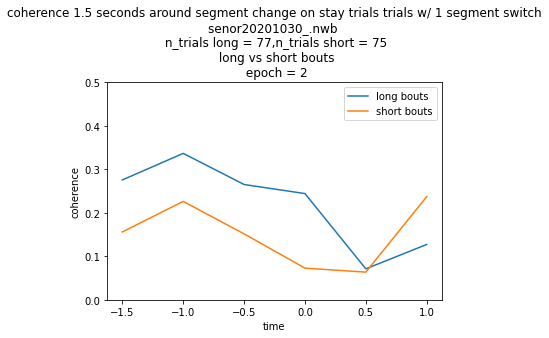

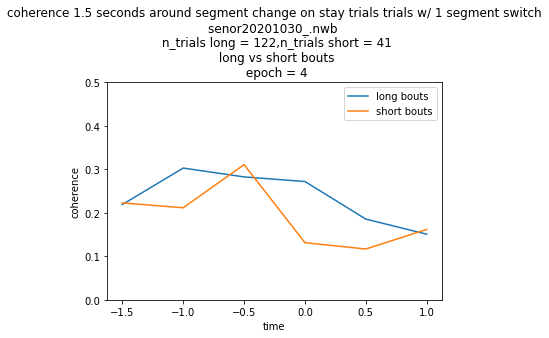

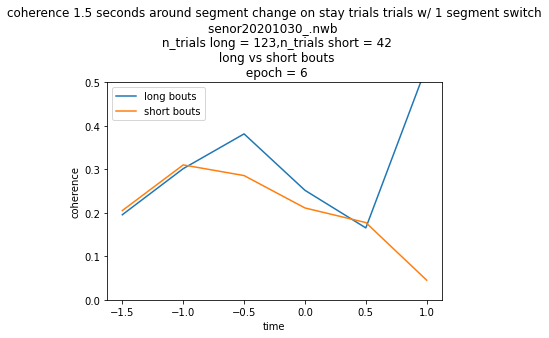

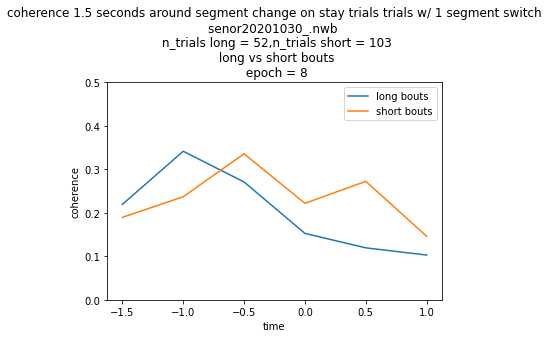

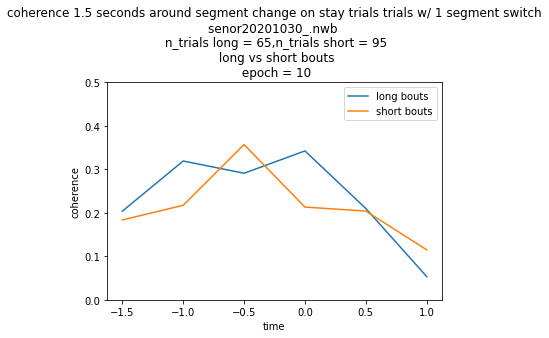

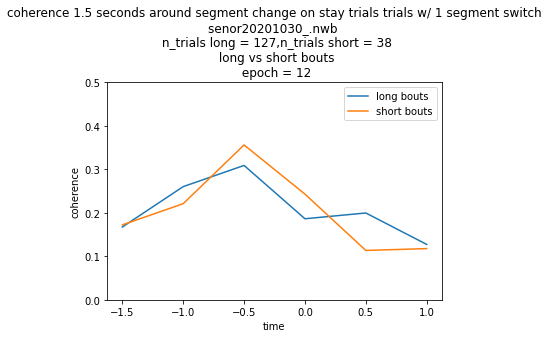

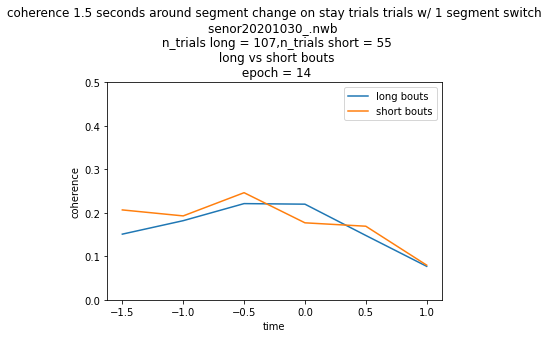

In [55]:

# stem='C'
for epoch in (range(2,(trial_data.epoch.max()+2),2)):
    time_at_center_short_bouts = []
    time_at_center_long_bouts=[]
    plt.figure()
    one_epoch = trial_data[trial_data.epoch==epoch]
    for ix in range(1,len(one_epoch)): 
        if one_epoch.iloc[ix].seg_switch_times!=0:
            if one_epoch.iloc[ix].stem_switch==False: 
                if len(one_epoch.iloc[ix].seg_switch_times) ==1:
                    if one_epoch.iloc[ix].bout_lens_per_bout>20:
                        time_at_center_long_bouts.append(one_epoch.iloc[ix].seg_switch_times[0])
                    else: 
                        time_at_center_short_bouts.append(one_epoch.iloc[ix].seg_switch_times[0])


    time_b4 = time_after = 1.5
    electrode_id_temp =[8,132]


    signal_long_bouts = get_signal_from_trialtimes(time_at_center_long_bouts, time_b4,time_after, electrode_id_temp, lfp_eseries, lfp_timestamps, lfp_data)
    signal_short_bouts = get_signal_from_trialtimes(time_at_center_short_bouts, time_b4,time_after, electrode_id_temp, lfp_eseries, lfp_timestamps, lfp_data)


    time, freq, mag, power,n_trials = multitaper_and_connectivity(signal_long_bouts,sampling_frequency,time_halfbandwidth_product,time_window_duration,time_window_step,-time_b4)
    coher_keeper=[]


    coh_seg = mag()[..., 0, 1].squeeze().T[(freq[0] == 8)]
    coher_keeper.append(coh_seg[0])

    n_trials_long = n_trials

    plt.plot(time,coher_keeper[0], label = 'long bouts')
    # plt.title(f'coherence {time_b4} seconds around segment change on stay trials trials w/ 1 segment switch\n{nwb_file_name} \n n_trials = {n_trials}\n after reward vs no rew')
    plt.xlabel('time') 
    plt.ylabel('coherence')                
    plt.ylim(0,.5)        


    coher_keeper=[]
    time, freq, mag, power,n_trials = multitaper_and_connectivity(signal_short_bouts,sampling_frequency,time_halfbandwidth_product,time_window_duration,time_window_step,-time_b4)

    coh_seg = mag()[..., 0, 1].squeeze().T[(freq[0] == 8)]

    coher_keeper.append(coh_seg[0])


    # plt.figure()
    plt.plot(time,coher_keeper[0], label = 'short bouts')
    plt.title(f'coherence {time_b4} seconds around segment change on stay trials trials w/ 1 segment switch\n{nwb_file_name} \n n_trials long = {n_trials_long},n_trials short = {n_trials}\n long vs short bouts\n epoch = {epoch}')
    plt.xlabel('time') 
    plt.ylabel('coherence')                
    plt.ylim(0,.5) 
    plt.legend()

Text(0.5, 1.0, 'bout numbers in one epoch (and implictly their lengths')

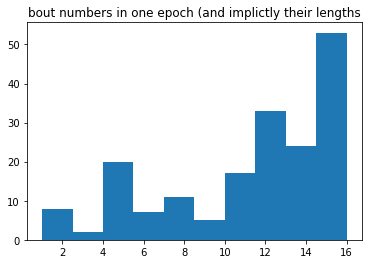

In [44]:
plt.hist(one_epoch['bout_num'])
plt.title('bout numbers in one epoch (and implictly their lengths')

In [ ]:
#want to split value up by thirds of number of samples 

In [57]:
halflife

3

(array([132., 128., 144., 146., 151., 123., 121., 108.,  79., 128.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

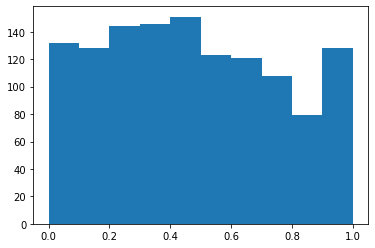

In [56]:

plt.hist(trial_data.rew_rate_ewm_leaf)


In [59]:
len(trial_data.rew_rate_ewm_leaf)/3

420.0

In [67]:
rew_rate_trials = trial_data.rew_rate_ewm_leaf.tolist()
rew_rate_trials.sort()

In [69]:
cutoff_first_third = rew_rate_trials[420]
cutoff_second_third = rew_rate_trials[840]

In [70]:
cutoff_first_third

0.31340389547072406

In [71]:
cutoff_second_third

0.6124540980704382

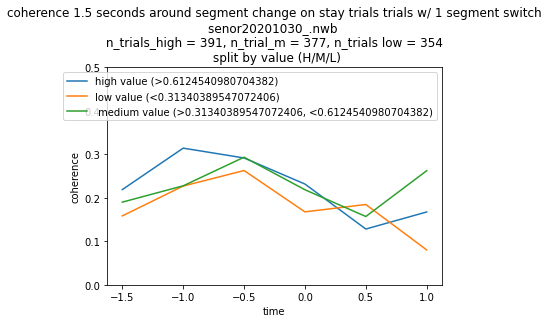

In [72]:
coher_keeper=[]
time_at_center_high_v = []
time_at_center_medium_v=[]
time_at_center_low_v=[]
# stem='C'

for ix in range(1,len(trial_data)): 
    if trial_data.iloc[ix].seg_switch_times!=0:
        if trial_data.iloc[ix].stem_switch==False: 
            if len(trial_data.iloc[ix].seg_switch_times) ==1:
                if trial_data.iloc[ix].rew_rate_ewm_leaf>cutoff_second_third:
                    time_at_center_high_v.append(trial_data.iloc[ix].seg_switch_times[0])
                elif  trial_data.iloc[ix].rew_rate_ewm_leaf<cutoff_first_third: 
                    time_at_center_low_v.append(trial_data.iloc[ix].seg_switch_times[0])
                else: 
                    time_at_center_medium_v.append(trial_data.iloc[ix].seg_switch_times[0])


                    

                    

time_b4 = time_after = 1.5
electrode_id_temp =[8,132]

    
signal = get_signal_from_trialtimes(time_at_center_high_v, time_b4,time_after, electrode_id_temp, lfp_eseries, lfp_timestamps, lfp_data)
signal_low = get_signal_from_trialtimes(time_at_center_low_v, time_b4,time_after, electrode_id_temp, lfp_eseries, lfp_timestamps, lfp_data)
signal_medium = get_signal_from_trialtimes(time_at_center_medium_v, time_b4,time_after, electrode_id_temp, lfp_eseries, lfp_timestamps, lfp_data)


time, freq, mag, power,n_trials_high = multitaper_and_connectivity(signal,sampling_frequency,time_halfbandwidth_product,time_window_duration,time_window_step,-time_b4)

coh_seg = mag()[..., 0, 1].squeeze().T[(freq[0] == 8)]
coher_keeper.append(coh_seg[0])



plt.plot(time,coher_keeper[0],label=f'high value (>{cutoff_second_third})')
# plt.title(f'coherence {time_b4} seconds around segment change on stay trials trials w/ 1 segment switch\n{nwb_file_name} \n n_trials = {n_trials}\n split by value (H/M/L)')#high value (>.66)')
plt.xlabel('time') 
plt.ylabel('coherence')                
plt.ylim(0,.5)        
               
    
coher_keeper=[]


time, freq, mag, power,n_trials_low = multitaper_and_connectivity(signal_low,sampling_frequency,time_halfbandwidth_product,time_window_duration,time_window_step,-time_b4)

coh_seg = mag()[..., 0, 1].squeeze().T[(freq[0] == 8)]

coher_keeper.append(coh_seg[0])


# plt.figure()
plt.plot(time,coher_keeper[0],label=f'low value (<{cutoff_first_third})')
# plt.title(f'coherence {time_b4} seconds around segment change on stay trials trials w/ 1 segment switch\n{nwb_file_name} \n n_trials = {n_trials}\n  lowvalue (<.33)')
plt.xlabel('time') 
plt.ylabel('coherence')                
plt.ylim(0,.5)     


coher_keeper=[]


time, freq, mag, power,n_trials = multitaper_and_connectivity(signal_medium,sampling_frequency,time_halfbandwidth_product,time_window_duration,time_window_step,-time_b4)

coh_seg = mag()[..., 0, 1].squeeze().T[(freq[0] == 8)]

coher_keeper.append(coh_seg[0])


# plt.figure()
plt.plot(time,coher_keeper[0],label=f' medium value (>{cutoff_first_third}, <{cutoff_second_third})')
plt.title(f'coherence {time_b4} seconds around segment change on stay trials trials w/ 1 segment switch\n{nwb_file_name} \n n_trials_high = {n_trials_high}, n_trial_m = {n_trials}, n_trials low = {n_trials_low} \n split by value (H/M/L)')#high value (>.66)')
plt.xlabel('time') 
plt.ylabel('coherence')                
plt.ylim(0,.5)
plt.legend()

In [ ]:
#abhilasha- gamma signifies high local communication 

In [ ]:
num_trials_per_contingency = 60



In [73]:
trial_data

nwb_file_name  epoch  trial_number_by_epoch  leaf stem  reward  \
0     senor20201030_.nwb      2                      0     4    B       0   
1     senor20201030_.nwb      2                      1     3    B       0   
2     senor20201030_.nwb      2                      2     2    A       0   
3     senor20201030_.nwb      2                      3     1    A       1   
4     senor20201030_.nwb      2                      4     2    A       1   
...                  ...    ...                    ...   ...  ...     ...   
1255  senor20201030_.nwb     14                    175     1    A       0   
1256  senor20201030_.nwb     14                    176     2    A       1   
1257  senor20201030_.nwb     14                    177     1    A       1   
1258  senor20201030_.nwb     14                    178     2    A       1   
1259  senor20201030_.nwb     14                    179     1    A       0   

        poke_in_ts  reward_on_ts  reward_off_ts   poke_out_ts  ...  \
0     1.604078e+09           NaN            NaN  1.604078e+09  ...   
1     1.604078e+09           NaN            NaN  1.604078e+09  ...   
2     1.604078e+09           NaN            NaN  1.604078e+09  ...   
3     1.604078e+09  1.604078e+09   1.604078e+09  1.604078e+09  ...   
4     1.604078e+09  1.604078e+09   1.604078e+09  1.604078e+09  ...   
...            ...           ...            ...           ...  ...   
1255  1.604104e+09           NaN            NaN  1.604104e+09  ...   
1256  1.604104e+09  1.604104e+09   1.604104e+09  1.604104e+09  ...   
1257  1.604104e+09  1.604104e+09   1.604104e+09  1.604104e+09  ...   
1258  1.604104e+09  1.604104e+09   1.604104e+09  1.604104e+09  ...   
1259  1.604104e+09           NaN            NaN  1.604104e+09  ...   

      p_rew_reset_leaf4  p_rew_reset_leaf5  p_rew_reset_leaf6  stem_switch  \
0                   NaN                NaN                NaN         True   
1                   NaN                NaN                NaN        False   
2                   NaN                NaN                NaN         True   
3                   NaN                NaN                NaN        False   
4                   NaN                NaN                NaN        False   
...                 ...                ...                ...          ...   
1255                NaN                NaN                NaN        False   
1256                NaN                NaN                NaN        False   
1257                NaN                NaN                NaN        False   
1258                NaN                NaN                NaN        False   
1259                NaN                NaN                NaN        False   

                                       seg_switch_times  rew_rate_ewm_leaf  \
0                                                     0           0.000000   
1                                  [1604078259.6768906]           0.000000   
2     [1604078268.4768033, 1604078268.810136, 160407...           0.000000   
3                                  [1604078279.2767003]           1.000000   
4                                  [1604078292.4099002]           0.571429   
...                                                 ...                ...   
1255                               [1604103536.0823658]           0.538468   
1256                               [1604103539.3156853]           0.334064   
1257                               [1604103545.7489443]           0.653879   
1258                               [1604103552.8488734]           0.500588   
1259                               [1604103559.7154639]           0.490380   

      rew_rate_ewm_stem  rew_rate_ewm_epoch  bout_num  bout_lens_per_bout  
0              0.000000            0.000000         1                 2.0  
1              0.000000            0.000000         1                 2.0  
2              0.000000            0.000000         2                 6.0  
3              0.571429            0.365714         2              

In [83]:
cont_num=[]
for ix in range(len(trial_data)):
    if trial_data.iloc[ix].trial_number_by_epoch <num_trials_per_contingency:
        cont_num.append(1)
    if trial_data.iloc[ix].trial_number_by_epoch >=num_trials_per_contingency:
        if trial_data.iloc[ix].trial_number_by_epoch < 2*num_trials_per_contingency:
            cont_num.append(2)
    if trial_data.iloc[ix].trial_number_by_epoch >= 2*num_trials_per_contingency: 
        cont_num.append(3)
trial_data['cont_num'] = cont_num



In [86]:
trial_data['cont_num'] = cont_num
trial_data

nwb_file_name  epoch  trial_number_by_epoch  leaf stem  reward  \
0     senor20201030_.nwb      2                      0     4    B       0   
1     senor20201030_.nwb      2                      1     3    B       0   
2     senor20201030_.nwb      2                      2     2    A       0   
3     senor20201030_.nwb      2                      3     1    A       1   
4     senor20201030_.nwb      2                      4     2    A       1   
...                  ...    ...                    ...   ...  ...     ...   
1255  senor20201030_.nwb     14                    175     1    A       0   
1256  senor20201030_.nwb     14                    176     2    A       1   
1257  senor20201030_.nwb     14                    177     1    A       1   
1258  senor20201030_.nwb     14                    178     2    A       1   
1259  senor20201030_.nwb     14                    179     1    A       0   

        poke_in_ts  reward_on_ts  reward_off_ts   poke_out_ts  ...  \
0     1.604078e+09           NaN            NaN  1.604078e+09  ...   
1     1.604078e+09           NaN            NaN  1.604078e+09  ...   
2     1.604078e+09           NaN            NaN  1.604078e+09  ...   
3     1.604078e+09  1.604078e+09   1.604078e+09  1.604078e+09  ...   
4     1.604078e+09  1.604078e+09   1.604078e+09  1.604078e+09  ...   
...            ...           ...            ...           ...  ...   
1255  1.604104e+09           NaN            NaN  1.604104e+09  ...   
1256  1.604104e+09  1.604104e+09   1.604104e+09  1.604104e+09  ...   
1257  1.604104e+09  1.604104e+09   1.604104e+09  1.604104e+09  ...   
1258  1.604104e+09  1.604104e+09   1.604104e+09  1.604104e+09  ...   
1259  1.604104e+09           NaN            NaN  1.604104e+09  ...   

      p_rew_reset_leaf5  p_rew_reset_leaf6  stem_switch  \
0                   NaN                NaN         True   
1                   NaN                NaN        False   
2                   NaN                NaN         True   
3                   NaN                NaN        False   
4                   NaN                NaN        False   
...                 ...                ...          ...   
1255                NaN                NaN        False   
1256                NaN                NaN        False   
1257                NaN                NaN        False   
1258                NaN                NaN        False   
1259                NaN                NaN        False   

                                       seg_switch_times  rew_rate_ewm_leaf  \
0                                                     0           0.000000   
1                                  [1604078259.6768906]           0.000000   
2     [1604078268.4768033, 1604078268.810136, 160407...           0.000000   
3                                  [1604078279.2767003]           1.000000   
4                                  [1604078292.4099002]           0.571429   
...                                                 ...                ...   
1255                               [1604103536.0823658]           0.538468   
1256                               [1604103539.3156853]           0.334064   
1257                               [1604103545.7489443]           0.653879   
1258                               [1604103552.8488734]           0.500588   
1259                               [1604103559.7154639]           0.490380   

      rew_rate_ewm_stem  rew_rate_ewm_epoch  bout_num  bout_lens_per_bout  \
0              0.000000            0.000000         1                 2.0   
1              0.000000            0.000000         1                 2.0   
2              0.000000            0.000000         2                 6.0   
3              0.571429            0.365714         2                 6.0   
4              0.756757            0.573624         2                 6.0   
...                 ...                 ...       ...                 ...   
1255           0.283583            0.337306        92       

In [87]:
time_at_center_first_cont=[]
time_at_center_second_cont=[]
time_at_center_third_cont=[]
for ix in range(1,len(trial_data)): 
    if trial_data.iloc[ix].seg_switch_times!=0:
        if trial_data.iloc[ix].stem_switch==False: 
            if len(trial_data.iloc[ix].seg_switch_times) ==1:
                if trial_data.iloc[ix].cont_num==1:
                    time_at_center_first_cont.append(trial_data.iloc[ix].seg_switch_times[0])
                elif  trial_data.iloc[ix].cont_num==2: 
                    time_at_center_second_cont.append(trial_data.iloc[ix].seg_switch_times[0])
                else: 
                    time_at_center_third_cont.append(trial_data.iloc[ix].seg_switch_times[0])

In [90]:
# len(time_at_center_first_cont)
# len(time_at_center_second_cont)
# len(time_at_center_third_cont)

393

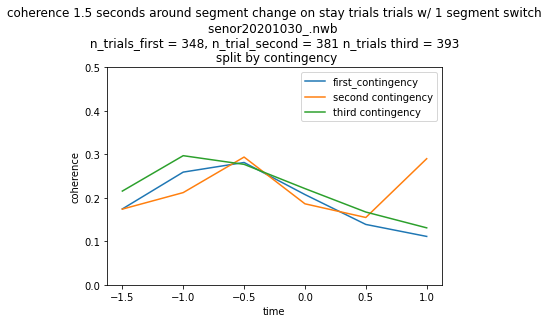

In [91]:
coher_keeper_first=[]
time_at_center_first_cont=[]
time_at_center_second_cont=[]
time_at_center_third_cont=[]
# stem='C'

for ix in range(1,len(trial_data)): 
    if trial_data.iloc[ix].seg_switch_times!=0:
        if trial_data.iloc[ix].stem_switch==False: 
            if len(trial_data.iloc[ix].seg_switch_times) ==1:
                if trial_data.iloc[ix].cont_num==1:
                    time_at_center_first_cont.append(trial_data.iloc[ix].seg_switch_times[0])
                elif  trial_data.iloc[ix].cont_num==2: 
                    time_at_center_second_cont.append(trial_data.iloc[ix].seg_switch_times[0])
                else: 
                    time_at_center_third_cont.append(trial_data.iloc[ix].seg_switch_times[0])


                    

                    

time_b4 = time_after = 1.5
electrode_id_temp =[8,132]

    
signal_first = get_signal_from_trialtimes(time_at_center_first_cont, time_b4,time_after, electrode_id_temp, lfp_eseries, lfp_timestamps, lfp_data)
signal_second = get_signal_from_trialtimes(time_at_center_second_cont, time_b4,time_after, electrode_id_temp, lfp_eseries, lfp_timestamps, lfp_data)
signal_third = get_signal_from_trialtimes(time_at_center_third_cont, time_b4,time_after, electrode_id_temp, lfp_eseries, lfp_timestamps, lfp_data)


time, freq, mag, power,n_trials_first = multitaper_and_connectivity(signal_first,sampling_frequency,time_halfbandwidth_product,time_window_duration,time_window_step,-time_b4)

coh_seg_first = mag()[..., 0, 1].squeeze().T[(freq[0] == 8)]
coher_keeper_first.append(coh_seg_first[0])



plt.plot(time,coher_keeper_first[0],label=f'first_contingency')
# plt.title(f'coherence {time_b4} seconds around segment change on stay trials trials w/ 1 segment switch\n{nwb_file_name} \n n_trials = {n_trials}\n split by value (H/M/L)')#high value (>.66)')
plt.xlabel('time') 
plt.ylabel('coherence')                
plt.ylim(0,.5)        
               
    
coher_keeper_second=[]


time, freq, mag, power,n_trials_second = multitaper_and_connectivity(signal_second,sampling_frequency,time_halfbandwidth_product,time_window_duration,time_window_step,-time_b4)

coh_seg_second = mag()[..., 0, 1].squeeze().T[(freq[0] == 8)]

coher_keeper_second.append(coh_seg_second[0])


# plt.figure()
plt.plot(time,coher_keeper_second[0],label=f'second contingency')
# plt.title(f'coherence {time_b4} seconds around segment change on stay trials trials w/ 1 segment switch\n{nwb_file_name} \n n_trials = {n_trials}\n  lowvalue (<.33)')
plt.xlabel('time') 
plt.ylabel('coherence')                
plt.ylim(0,.5)     


coher_keeper_third=[]


time, freq, mag, power,n_trials = multitaper_and_connectivity(signal_third,sampling_frequency,time_halfbandwidth_product,time_window_duration,time_window_step,-time_b4)

coh_seg_third = mag()[..., 0, 1].squeeze().T[(freq[0] == 8)]

coher_keeper_third.append(coh_seg_third[0])


# plt.figure()
plt.plot(time,coher_keeper_third[0],label=f'third contingency')
plt.title(f'coherence {time_b4} seconds around segment change on stay trials trials w/ 1 segment switch\n{nwb_file_name} \n n_trials_first = {n_trials_first}, n_trial_second = {n_trials_second} n_trials third = {n_trials} \n split by contingency')#high value (>.66)')
plt.xlabel('time') 
plt.ylabel('coherence')                
plt.ylim(0,.5)
plt.legend()

In [ ]:
#separate by contingency? for a cuople of reasons. just to see if theres any coherence differences in each contingency, but also to see different bouts legnths
#are there obvious epxlore and exploit in each conteingency? 

In [110]:
trial_data

nwb_file_name  epoch  trial_number_by_epoch  leaf stem  reward  \
0     senor20201030_.nwb      2                      0     4    B       0   
1     senor20201030_.nwb      2                      1     3    B       0   
2     senor20201030_.nwb      2                      2     2    A       0   
3     senor20201030_.nwb      2                      3     1    A       1   
4     senor20201030_.nwb      2                      4     2    A       1   
...                  ...    ...                    ...   ...  ...     ...   
1255  senor20201030_.nwb     14                    175     1    A       0   
1256  senor20201030_.nwb     14                    176     2    A       1   
1257  senor20201030_.nwb     14                    177     1    A       1   
1258  senor20201030_.nwb     14                    178     2    A       1   
1259  senor20201030_.nwb     14                    179     1    A       0   

        poke_in_ts  reward_on_ts  reward_off_ts   poke_out_ts  ...  \
0     1.604078e+09           NaN            NaN  1.604078e+09  ...   
1     1.604078e+09           NaN            NaN  1.604078e+09  ...   
2     1.604078e+09           NaN            NaN  1.604078e+09  ...   
3     1.604078e+09  1.604078e+09   1.604078e+09  1.604078e+09  ...   
4     1.604078e+09  1.604078e+09   1.604078e+09  1.604078e+09  ...   
...            ...           ...            ...           ...  ...   
1255  1.604104e+09           NaN            NaN  1.604104e+09  ...   
1256  1.604104e+09  1.604104e+09   1.604104e+09  1.604104e+09  ...   
1257  1.604104e+09  1.604104e+09   1.604104e+09  1.604104e+09  ...   
1258  1.604104e+09  1.604104e+09   1.604104e+09  1.604104e+09  ...   
1259  1.604104e+09           NaN            NaN  1.604104e+09  ...   

      p_rew_reset_leaf5  p_rew_reset_leaf6  stem_switch  \
0                   NaN                NaN         True   
1                   NaN                NaN        False   
2                   NaN                NaN         True   
3                   NaN                NaN        False   
4                   NaN                NaN        False   
...                 ...                ...          ...   
1255                NaN                NaN        False   
1256                NaN                NaN        False   
1257                NaN                NaN        False   
1258                NaN                NaN        False   
1259                NaN                NaN        False   

                                       seg_switch_times  rew_rate_ewm_leaf  \
0                                                     0           0.000000   
1                                  [1604078259.6768906]           0.000000   
2     [1604078268.4768033, 1604078268.810136, 160407...           0.000000   
3                                  [1604078279.2767003]           1.000000   
4                                  [1604078292.4099002]           0.571429   
...                                                 ...                ...   
1255                               [1604103536.0823658]           0.538468   
1256                               [1604103539.3156853]           0.334064   
1257                               [1604103545.7489443]           0.653879   
1258                               [1604103552.8488734]           0.500588   
1259                               [1604103559.7154639]           0.490380   

      rew_rate_ewm_stem  rew_rate_ewm_epoch  bout_num  bout_lens_per_bout  \
0              0.000000            0.000000         1                 2.0   
1              0.000000            0.000000         1                 2.0   
2              0.000000            0.000000         2                 6.0   
3              0.571429            0.365714         2                 6.0   
4              0.756757            0.573624         2                 6.0   
...                 ...                 ...       ...                 ...   
1255           0.283583            0.337306        13       

In [ ]:
bouts

In [104]:
epoch_data=[]
for ix in range(0,trial_data.epoch.max()+2,2):
    epoch_df = trial_data[trial_data.epoch==ix]
    epoch_data.append(epoch_df['stem'].ne(epoch_df['stem'].shift()).cumsum().tolist())
mylist = [item for sublist in epoch_data for item in sublist]
trial_data['bout_num'] = mylist




In [118]:
obj=['epoch','bout_num']
bout_len = trial_data.groupby(obj).size()

In [133]:
bout_len=[]
for ix in range(2,trial_data.epoch.max()+2,2):
    epoch_df = trial_data[trial_data.epoch==ix]
    for bout in range(1,int(epoch_df.bout_num.max()+1)):
        bout_len.append(len(epoch_df[epoch_df.bout_num == bout]))


In [139]:
2*np.ones(2)

array([2., 2.])

In [151]:
bout_len_tracker=[]
for ix in range(len(bout_len)):
    bout_len_ix = bout_len[ix]
    bout_len_tracker.append((bout_len_ix*(np.ones(bout_len_ix))).tolist())


In [157]:
bout_len_tracker
mylist = [item for sublist in bout_len_tracker for item in sublist]
trial_data['bout_lens_per_bout'] = mylist




In [167]:
bouts=[]
bouts1=[]


for ix in range(len(trial_data)):
    if trial_data.iloc[ix].cont_num ==1: 
        bouts.append([trial_data.iloc[ix].epoch, trial_data.iloc[ix].bout_num,trial_data.iloc[ix].bout_lens_per_bout])
        bouts1.append([trial_data.iloc[ix].bout_num,trial_data.iloc[ix].bout_lens_per_bout])

Text(0.5, 1.0, 'bout lengths per bout number over day, first contingency')

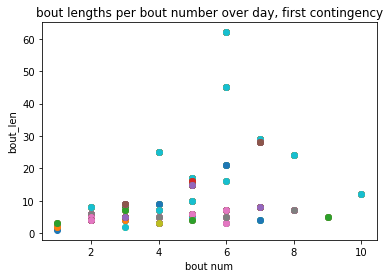

In [172]:
for ix in range(len(bouts1)):
    bout_eg = bouts1[ix]
    plt.scatter(bout_eg[0],bout_eg[1])
plt.xlabel('bout num')
plt.ylabel('bout_len')
plt.title('bout lengths per bout number over day, first contingency')

In [ ]:
bouts

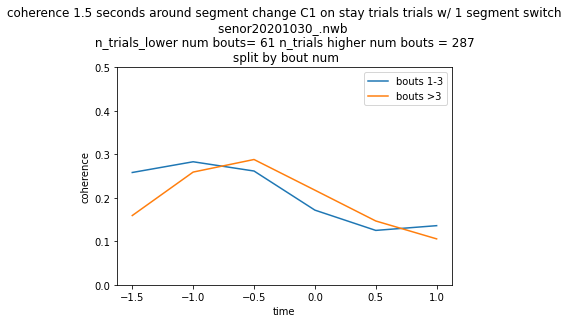

In [176]:
coher_keeper_first=[]
time_at_center_lower_bouts=[]
time_at_center_upper_bouts=[]
# time_at_center_third_cont=[]
# stem='C'

for ix in range(1,len(trial_data)): 
    if trial_data.iloc[ix].seg_switch_times!=0:
        if trial_data.iloc[ix].stem_switch==False: 
            if len(trial_data.iloc[ix].seg_switch_times) ==1:
                if trial_data.iloc[ix].cont_num==1:
                    if trial_data.iloc[ix].bout_num <=3:
                        time_at_center_lower_bouts.append(trial_data.iloc[ix].seg_switch_times[0])
                    else: 
                        time_at_center_upper_bouts.append(trial_data.iloc[ix].seg_switch_times[0])




                    

                    

time_b4 = time_after = 1.5
electrode_id_temp =[8,132]

    
signal_first = get_signal_from_trialtimes(time_at_center_lower_bouts, time_b4,time_after, electrode_id_temp, lfp_eseries, lfp_timestamps, lfp_data)
signal_second = get_signal_from_trialtimes(time_at_center_upper_bouts, time_b4,time_after, electrode_id_temp, lfp_eseries, lfp_timestamps, lfp_data)


time, freq, mag, power,n_trials_first = multitaper_and_connectivity(signal_first,sampling_frequency,time_halfbandwidth_product,time_window_duration,time_window_step,-time_b4)

coh_seg_first = mag()[..., 0, 1].squeeze().T[(freq[0] == 8)]
coher_keeper_first.append(coh_seg_first[0])



plt.plot(time,coher_keeper_first[0],label=f'bouts 1-3')
# plt.title(f'coherence {time_b4} seconds around segment change on stay trials trials w/ 1 segment switch\n{nwb_file_name} \n n_trials = {n_trials}\n split by value (H/M/L)')#high value (>.66)')
plt.xlabel('time') 
plt.ylabel('coherence')                
plt.ylim(0,.5)        
               
    
coher_keeper_second=[]


time, freq, mag, power,n_trials_second = multitaper_and_connectivity(signal_second,sampling_frequency,time_halfbandwidth_product,time_window_duration,time_window_step,-time_b4)

coh_seg_second = mag()[..., 0, 1].squeeze().T[(freq[0] == 8)]

coher_keeper_second.append(coh_seg_second[0])



# plt.figure()
plt.plot(time,coher_keeper_second[0],label=f'bouts >3')
plt.title(f'coherence {time_b4} seconds around segment change C1 on stay trials trials w/ 1 segment switch\n{nwb_file_name} \n n_trials_lower num bouts= {n_trials_first} n_trials higher num bouts = {n_trials_second} \n split by bout num')#high value (>.66)')
plt.xlabel('time') 
plt.ylabel('coherence')                
plt.ylim(0,.5)
plt.legend()